# Code plagarism detector

## Import libraries

In [48]:
import os
import pandas as pd
from pathlib import Path
import shutil
import json
import javalang
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Configuración de directorios
#BASE_DIR = "C:\\Users\\fmend\\OneDrive\\Escritorio\\8vo\\Code-Plagiarism-Detector"
BASE_DIR = "C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas/Code-Plagiarism-Detector"

IR_PLAG_DATASET = os.path.join(BASE_DIR, "IR-Plag-Dataset")
FIRE14_DATASET = os.path.join(BASE_DIR, "fire14-source-code-training-dataset")
FIRE14_QREL = os.path.join(FIRE14_DATASET, "SOCO14-java.qrel")
COMBINED_DATASET = os.path.join(BASE_DIR, "IR-Plag-Dataset/data")
MODEL_DIR = os.path.join(BASE_DIR, "model")


# Funciones para preparar el dataset

In [49]:
def process_fire14(fire14_path, qrel_path, output_path):
    Path(f"{output_path}/raw_files/fire14").mkdir(parents=True, exist_ok=True)
    
    for java_file in Path(fire14_path).glob('java/*.java'):
        shutil.copy(java_file, f"{output_path}/raw_files/fire14/{java_file.name}")
    
    pairs = []
    with open(qrel_path, 'r') as f:
        for line in f:
            if line.strip():
                file1, file2 = line.strip().split()
                pair_id = f"fire14_{file1.split('.')[0]}_{file2.split('.')[0]}"
                pair_dir = f"{output_path}/pairs/{pair_id}"
                Path(pair_dir).mkdir(parents=True, exist_ok=True)
                
                metadata = {
                    "source": "FIRE14",
                    "plagiarism_type": "monolingual",
                    "dataset": "SOCO14",
                    "files": [file1, file2],
                    "label": 1
                }
                
                with open(f"{pair_dir}/metadata.json", 'w') as mf:
                    json.dump(metadata, mf)
                
                pairs.append({
                    "pair_id": pair_id,
                    "file1": f"{output_path}/raw_files/fire14/{file1}",
                    "file2": f"{output_path}/raw_files/fire14/{file2}",
                    "label": 1,
                    "source": "FIRE14"
                })
    
    return pd.DataFrame(pairs)


In [50]:
def process_ir_plag(ir_plag_path, output_path):
    Path(f"{output_path}/raw_files/ir_plag").mkdir(parents=True, exist_ok=True)
    pairs = []
    
    for case_dir in Path(ir_plag_path).iterdir():
        if case_dir.is_dir():
            case_id = case_dir.name
            original_files = list(case_dir.glob('original/*.java'))
            
            for orig_file in original_files:
                for plag_file in case_dir.glob('plagiarized/**/*.java'):
                    plag_level = plag_file.parent.parent.name
                    pair_id = f"irplag_{case_id}_{plag_file.stem}"
                    pair_dir = f"{output_path}/pairs/{pair_id}"
                    Path(pair_dir).mkdir(parents=True, exist_ok=True)
                    
                    metadata = {
                        "source": "IR-Plag",
                        "plagiarism_level": plag_level.replace('L', ''),
                        "dataset": "IR-Plag",
                        "files": [orig_file.name, plag_file.name],
                        "label": 1
                    }
                    with open(f"{pair_dir}/metadata.json", 'w') as mf:
                        json.dump(metadata, mf)
                    
                    new_orig = f"{output_path}/raw_files/ir_plag/{orig_file.name}"
                    new_plag = f"{output_path}/raw_files/ir_plag/{plag_file.name}"
                    shutil.copy(orig_file, new_orig)
                    shutil.copy(plag_file, new_plag)
                    
                    pairs.append({
                        "pair_id": pair_id,
                        "file1": new_orig,
                        "file2": new_plag,
                        "label": 1,
                        "source": "IR-Plag",
                        "plagiarism_level": plag_level.replace('L', '')
                    })
                
                for non_plag_file in case_dir.glob('non-plagiarized/**/*.java'):
                    pair_id = f"irplag_{case_id}_{non_plag_file.stem}"
                    pair_dir = f"{output_path}/pairs/{pair_id}"
                    Path(pair_dir).mkdir(parents=True, exist_ok=True)
                    
                    metadata = {
                        "source": "IR-Plag",
                        "plagiarism_level": None,
                        "dataset": "IR-Plag",
                        "files": [orig_file.name, non_plag_file.name],
                        "label": 0
                    }
                    with open(f"{pair_dir}/metadata.json", 'w') as mf:
                        json.dump(metadata, mf)
                    
                    new_non_plag = f"{output_path}/raw_files/ir_plag/{non_plag_file.name}"
                    shutil.copy(non_plag_file, new_non_plag)
                    
                    pairs.append({
                        "pair_id": pair_id,
                        "file1": new_orig,
                        "file2": new_non_plag,
                        "label": 0,
                        "source": "IR-Plag",
                        "plagiarism_level": None
                    })
    
    return pd.DataFrame(pairs)


In [51]:
def create_combined_dataset():
    print("Creando dataset combinado...")
    fire14_df = process_fire14(FIRE14_DATASET, FIRE14_QREL, COMBINED_DATASET)
    ir_plag_df = process_ir_plag(IR_PLAG_DATASET, COMBINED_DATASET)
    
    combined_df = pd.concat([fire14_df, ir_plag_df])
    combined_df.to_csv(f"{COMBINED_DATASET}/metadata.csv", index=False)
    
    print(f"\nDataset combinado creado en {COMBINED_DATASET}")
    print("\nDistribución de clases:")
    print(combined_df['label'].value_counts())
    print("\nDistribución por fuente:")
    print(combined_df['source'].value_counts())
    
    return combined_df


In [52]:
def prepare_training_data(combined_df):
    features= ['similarity', 'jaccard_similarity', 'jaccard_similarity_ast', 'cosine_similarity_text']
    #features= ['similarity', 'jaccard_similarity', 'jaccard_similarity_ast']

    print("\nPreparando datos para entrenamiento...")
    print("Extrayendo tokens AST...")
    all_files = set(combined_df['file1']).union(set(combined_df['file2']))
    ast_texts = [ast_token_string(file) for file in all_files]
    
    vectorizer = TfidfVectorizer()
    vectorizer.fit(ast_texts)
    if "cosine_similarity_text" in features:
        print("Calculando cosine similarity (text)...")
        combined_df['cosine_similarity_text'] = combined_df.apply(
            lambda x: calculate_similarity(x, vectorizer), axis=1)
        
    if("similarity" in features):
        print("Calculando cosine similarity para archivos...")
        combined_df['similarity'] = combined_df.apply(
            lambda x: calculate_cosine_similarity_files(x), axis=1)
        combined_df = combined_df[combined_df['similarity'] > 0]
    
    if("jaccard_similarity" in features):
        print("Calculando jaccard similarity...")
        combined_df['jaccard_similarity'] = combined_df.apply(
            lambda x: calculate_jaccard_similarity(x), axis=1)
    
    if("jaccard_similarity_ast" in features):
        print("Calcular jaccard similarity (AST tokens)...")
        combined_df['jaccard_similarity_ast'] = combined_df.apply(
            lambda x: calculate_jaccard_similarity_ast_tokens(x), axis=1)
    
    
    print("Balanceando dataset...")
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(
        combined_df[features], combined_df['label'])
    balanced_df = combined_df.iloc[X_res.index]
    
    print("Dividiendo en train/test...")
    X = balanced_df[features]
    y = balanced_df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test, vectorizer


# Funciones Auxiliares para definir Features

In [53]:
def ast_token_string(file_path):
    """Convierte un archivo Java en una cadena de tokens AST"""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            code = f.read()
        tree = javalang.parse.parse(code)
        tokens = [type(node).__name__ for path, node in tree]
        return ' '.join(tokens) if tokens else ''
    except Exception as e:
        print(f"Error parsing {file_path}: {str(e)}")
        return ''

def calculate_similarity(pair, vectorizer):
    try:
        ast1 = ast_token_string(pair['file1'])
        ast2 = ast_token_string(pair['file2'])
        vec1 = vectorizer.transform([ast1])
        vec2 = vectorizer.transform([ast2])
        return cosine_similarity(vec1, vec2)[0][0]
    except Exception as e:
        print(f"Error calculating similarity: {str(e)}")
        return 0
    
def calculate_cosine_similarity_files(pair):
    """Calculates cosine similarity between two text files."""
    try:
        # Read file1 and file2
        with open(pair['file1'], 'r', encoding='utf-8', errors='ignore') as f:
            text1 = f.read()
        
        with open(pair['file2'], 'r', encoding='utf-8', errors='ignore') as f:
            text2 = f.read()
        
        # Create a TfidfVectorizer
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        
        # Calculate cosine similarity
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    
    except Exception as e:
        print(f"Error calculating cosine similarity for {pair}: {str(e)}")
        return 0.0


def calculate_jaccard_similarity_ast_tokens(pair):
    try:
        ast1 = ast_token_string(pair['file1'])
        ast2 = ast_token_string(pair['file2'])
        set1 = set(ast1.split())
        set2 = set(ast2.split())
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0
    except Exception as e:
        print(f"Error calculating Jaccard similarity: {str(e)}")
        return 
    
def calculate_jaccard_similarity(pair):
    """Computes Jaccard similarity between two text files (word-level)."""
    try:
        # Read file1 and split into words
        with open(pair['file1'], 'r', encoding='utf-8', errors='ignore') as f:
            words1 = set(f.read().split())  # Default: splits by whitespace
        
        # Read file2 and split into words
        with open(pair['file2'], 'r', encoding='utf-8', errors='ignore') as f:
            words2 = set(f.read().split())
        
        # Compute Jaccard similarity: |A ∩ B| / |A ∪ B|
        intersection = len(words1 & words2)  # Or: words1.intersection(words2)
        union = len(words1 | words2)        # Or: words1.union(words2)
        
        return intersection / union if union > 0 else 0.0
    
    except Exception as e:
        print(f"Error calculating Jaccard similarity for {pair}: {str(e)}")
        return 0.0



## Funciones auxiliares para entrenar y evaluar el modelo

In [54]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Plagio', 'Plagio'],
                yticklabels=['No Plagio', 'Plagio'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

In [55]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    print("\nEntrenando modelo...")

    model.fit(X_train, y_train)
    
    print("\nEvaluación en conjunto de entrenamiento:")
    evaluate_model(model, X_train, y_train)
    
    print("\nEvaluación en conjunto de prueba:")
    evaluate_model(model, X_test, y_test)
    
    return model


# Bitacora de modelos

In [56]:
model_name= "RandomForestClassifier"
model_version = "v1_0"
model_random_forest = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )

import xgboost as xgb

model_name = "XGBoostClassifier"
model_version = "v1_0"
model_xgboost = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    min_child_weight=5,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
#Este modelo estimaba todo como plagio, por lo que se ajustó el scale_pos_weight

model_name = "XGBoostClassifier"
model_version = "v2_0"
model_xgboost = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,  # reasonable default
    min_child_weight=5,
    scale_pos_weight=12/100,  # 👈 imbalance ratio (minority / majority)
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model_name = "XGBoostClassifier"
model_version = "v2_0"
model_xgboost = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,  # reasonable default
    min_child_weight=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model_name = "XGBoostClassifier"
model_version = "v3_0"

num_pos = 105   # clase 0 (minoritaria)
num_neg = 439   # clase 1 (mayoritaria)
imbalance_ratio = num_pos / num_neg  # ≈ 0.239

model_xgboost_v3 = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    min_child_weight=5,
    scale_pos_weight=imbalance_ratio,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)



<string>:8: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
C:\Users\adria\AppData\Local\Temp\ipykernel_24328\482998255.py:8: SyntaxWarning: invalid escape sequence '\{'
  model_dir = MODEL_DIR+ f"\{model_name}\{model_version}"
C:\Users\adria\AppData\Local\Temp\ipykernel_24328\482998255.py:8: SyntaxWarning: invalid escape sequence '\{'
  model_dir = MODEL_DIR+ f"\{model_name}\{model_version}"


Creando dataset combinado...

Dataset combinado creado en C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas/Code-Plagiarism-Detector\IR-Plag-Dataset/data

Distribución de clases:
label
1    439
0    105
Name: count, dtype: int64

Distribución por fuente:
source
IR-Plag    460
FIRE14      84
Name: count, dtype: int64

Preparando datos para entrenamiento...
Extrayendo tokens AST...
Calculando cosine similarity (text)...
Calculando cosine similarity para archivos...
Calculando jaccard similarity...
Calcular jaccard similarity (AST tokens)...
Balanceando dataset...
Dividiendo en train/test...

Entrenando modelo...

Evaluación en conjunto de entrenamiento:
Accuracy: 0.9762
Precision: 0.9868
Recall: 0.9868
F1 Score: 0.9868


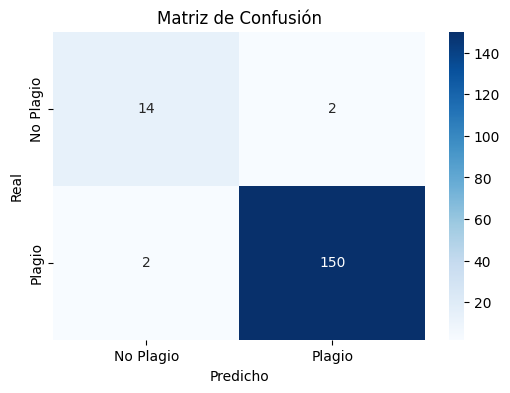


Evaluación en conjunto de prueba:
Accuracy: 0.8810
Precision: 0.9714
Recall: 0.8947
F1 Score: 0.9315


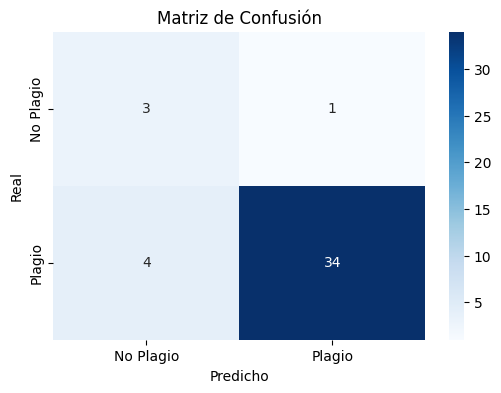

Guardando vectorizador...

Modelo guardado en C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas/Code-Plagiarism-Detector\model\XGBoostClassifier\v3_0


In [ ]:
model = model_random_forest

combined_df = create_combined_dataset()
X_train, X_test, y_train, y_test, vectorizer = prepare_training_data(combined_df)
model = train_and_evaluate(model, X_train, X_test, y_train, y_test)

# Guardar modelo
model_dir = os.path.join(MODEL_DIR, model_name, model_version)
#Make sure the directory exists
Path(model_dir).mkdir(parents=True, exist_ok=True)
joblib.dump(model, os.path.join(model_dir, f'{model_name}_{model_version}.pkl'))
if vectorizer is not None:
    print("Guardando vectorizador...")
    # Guardar vectorizador
    joblib.dump(vectorizer, os.path.join(model_dir, 'vectorizer.pkl'))

print(f"\nModelo guardado en {model_dir}")


In [ ]:
#Verificar columnas de entrenamiento
print(X_test.columns)
print(X_train.columns)

Index(['similarity', 'jaccard_similarity', 'jaccard_similarity_ast',
       'cosine_similarity_text'],
      dtype='object')
Index(['similarity', 'jaccard_similarity', 'jaccard_similarity_ast',
       'cosine_similarity_text'],
      dtype='object')


# Interfaz optional para ejecutar el modelos

In [ ]:
# def detect_plagiarism(file1_path, file2_path, model, vectorizer, threshold=0.5):

#     # Calcular similitud
#     similarity = calculate_similarity({'file1': file1_path, 'file2': file2_path}, vectorizer)
    
#     # Predecir con el modelo
#     prediction = model.predict([[similarity]])[0]
#     proba = model.predict_proba([[similarity]])[0][1]
    
#     # Interpretar resultados
#     result = {
#         'similarity_score': similarity,
#         'prediction': 'Plagio' if prediction == 1 else 'No Plagio',
#         'confidence': proba,
#         'is_plagiarism': proba >= threshold
#     }
    
#     return result

# def interactive_plagiarism_detector():
#     """Interfaz interactiva para probar el detector de plagio"""
#     print("=== Detector de Plagio en Código Java ===")
#     print("Por favor, proporcione las rutas a los archivos a comparar")
    
#     file1 = input("Ruta al archivo ORIGINAL (.java): ").strip()
#     file2 = input("Ruta al archivo a COMPARAR (.java): ").strip()
    
#     if not os.path.exists(file1) or not os.path.exists(file2):
#         print("Error: Uno o ambos archivos no existen.")
#         return
    
#     if not file1.endswith('.java') or not file2.endswith('.java'):
#         print("Error: Ambos archivos deben ser .java")
#         return
    
#     print("\nAnalizando...")
#     result = detect_plagiarism(file1, file2, model, vectorizer)
    
#     print("\n=== Resultados ===")
#     print(f"Similitud estructural (AST): {result['similarity_score']:.4f}")
#     print(f"Predicción: {result['prediction']}")
#     print(f"Confianza: {result['confidence']:.2%}")
    


In [ ]:
# interactive_plagiarism_detector()


=== Detector de Plagio en Código Java ===
Por favor, proporcione las rutas a los archivos a comparar
Error: Uno o ambos archivos no existen.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 3. Modelo de regresión logística
model_name = "LogisticRegression"
model_version = "v1_0"

model_logistic = LogisticRegression(
    class_weight='balanced',  # Muy importante en datos desbalanceados
    random_state=42,
    max_iter=1000
)

# 4. Entrenamiento
model_logistic.fit(X_train, y_train)

# 5. Evaluación
y_pred = model_logistic.predict(X_test)

print(f"Modelo: {model_name} - Versión: {model_version}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Modelo: LogisticRegression - Versión: v1_0
[[ 3  1]
 [ 7 31]]
              precision    recall  f1-score   support

           0     0.3000    0.7500    0.4286         4
           1     0.9688    0.8158    0.8857        38

    accuracy                         0.8095        42
   macro avg     0.6344    0.7829    0.6571        42
weighted avg     0.9051    0.8095    0.8422        42

